In [1]:
import pandas as pd
from sklearn.model_selection import GroupKFold
import numpy as np

# Load data
train = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/train.csv")
test = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv")



In [2]:
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
from IPython.display import display


2025-09-25 18:58:21.814361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758826702.105257      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758826702.189349      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
print(train.describe().T)

               count          mean           std        min           25%  \
id         6036000.0  3.018000e+06  1.742443e+06   1.000000  1.509001e+06   
breath_id  6036000.0  6.283886e+04  3.633526e+04   1.000000  3.137700e+04   
R          6036000.0  2.703618e+01  1.959549e+01   5.000000  5.000000e+00   
C          6036000.0  2.608072e+01  1.715231e+01  10.000000  1.000000e+01   
time_step  6036000.0  1.307225e+00  7.659778e-01   0.000000  6.428995e-01   
u_in       6036000.0  7.321615e+00  1.343470e+01   0.000000  3.936623e-01   
u_out      6036000.0  6.204493e-01  4.852752e-01   0.000000  0.000000e+00   
pressure   6036000.0  1.122041e+01  8.109703e+00  -1.895744  6.329607e+00   

                    50%           75%           max  
id         3.018000e+06  4.527000e+06  6.036000e+06  
breath_id  6.276550e+04  9.430100e+04  1.257490e+05  
R          2.000000e+01  5.000000e+01  5.000000e+01  
C          2.000000e+01  5.000000e+01  5.000000e+01  
time_step  1.308123e+00  1.965502e+0

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [6]:
train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [7]:
train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


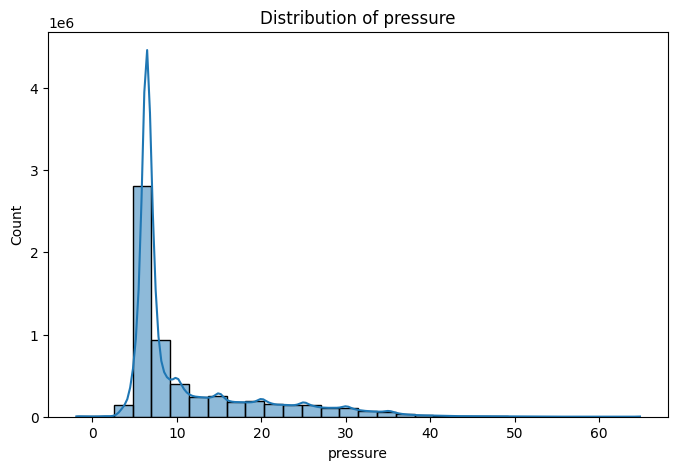

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(train['pressure'], kde=True, bins=30)
plt.title(f"Distribution of {'pressure'}")
plt.show()

In [9]:
train=train.drop(['id'],axis=1)

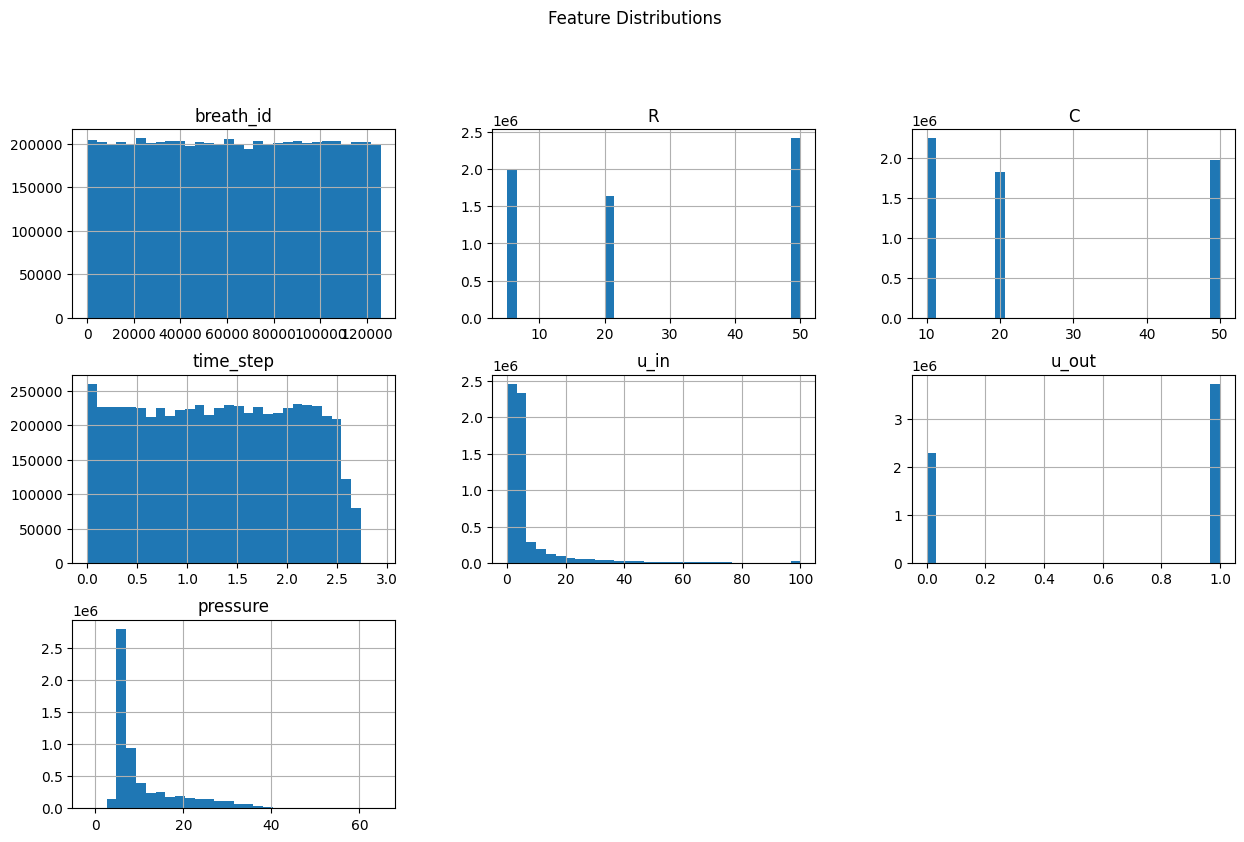

In [10]:
num_features = train.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms for all numeric features
train[num_features].hist(bins=30, figsize=(15,12), layout=(4,3))
plt.suptitle("Feature Distributions")
plt.show()

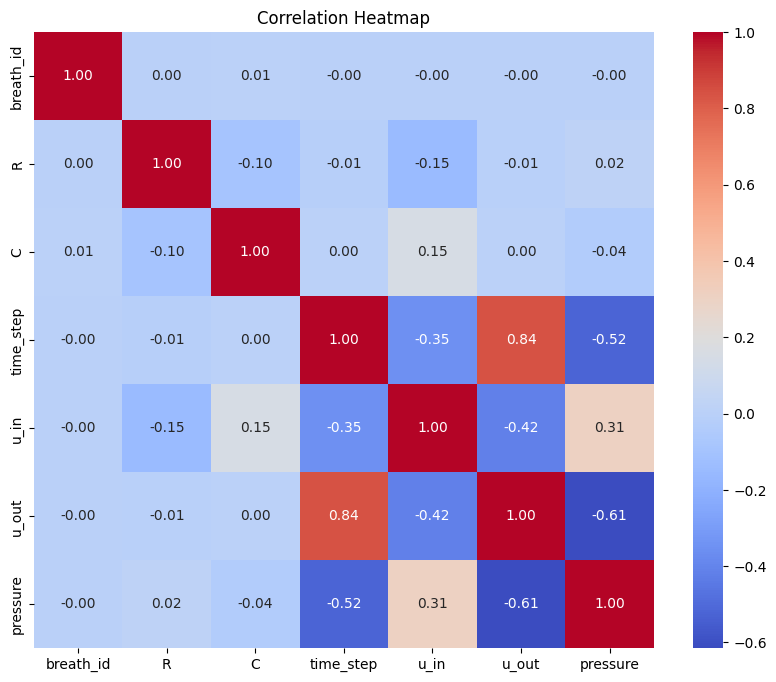

In [11]:
plt.figure(figsize=(10,8))
sns.heatmap(train[num_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [12]:
train.shape

(6036000, 7)

In [13]:
test.shape

(4024000, 7)

In [14]:
import pandas as pd
import numpy as np

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    # --- 1. Basic breath-wise cumulative features ---
    df['u_in_cumsum'] = df.groupby('breath_id')['u_in'].cumsum()
    # cumulative mean = cumulative sum / count so far
    df['u_in_cummean'] = df['u_in_cumsum'] / (df.groupby('breath_id').cumcount() + 1)

    # --- 2. Lag features ---
    for lag in [1, 2, 3]:
        df[f'u_in_lag{lag}'] = df.groupby('breath_id')['u_in'].shift(lag).fillna(0)
        df[f'du_in_lag{lag}'] = df['u_in'] - df[f'u_in_lag{lag}']

    # --- 3. Time-related features ---
    df['time_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['u_in_rate'] = df.groupby('breath_id')['u_in'].diff().fillna(0) / df['time_diff'].replace(0, 1)

    # --- 4. Rolling statistics ---
    df['u_in_rolling_mean'] = (
        df.groupby('breath_id')['u_in']
        .rolling(window=5, min_periods=1).mean()
        .reset_index(0, drop=True)
    )
    df['u_in_rolling_std'] = (
        df.groupby('breath_id')['u_in']
        .rolling(window=5, min_periods=1).std()
        .reset_index(0, drop=True)
        .fillna(0)
    )

    # --- 5. Phase features ---
    df['phase_inhale'] = (df['u_out'] == 0).astype(int)
    df['phase_exhale'] = (df['u_out'] == 1).astype(int)

    # step index (0,1,2,...) within each breath
    step_index = df.groupby('breath_id').cumcount()
    step_count = df.groupby('breath_id')['time_step'].transform('count')
    df['step_pos'] = step_index / step_count

    # --- 6. Statistical features per breath (broadcast back to all rows) ---
    for col in ['u_in', 'u_in_cumsum']:
        df[f'{col}_mean'] = df.groupby('breath_id')[col].transform('mean')
        df[f'{col}_max'] = df.groupby('breath_id')[col].transform('max')
        df[f'{col}_min'] = df.groupby('breath_id')[col].transform('min')
        df[f'{col}_std'] = df.groupby('breath_id')[col].transform('std')

    return df

train = create_features(train)
test = create_features(test)

In [15]:
train.head()

,breath_id,R,C,time_step,u_in,u_out,pressure,u_in_cumsum,u_in_cummean,u_in_lag1,...,phase_exhale,step_pos,u_in_mean,u_in_max,u_in_min,u_in_std,u_in_cumsum_mean,u_in_cumsum_max,u_in_cumsum_min,u_in_cumsum_std
0,1,20,50,0.000000,0.083334,0,5.837492,0.083334,0.083334,0.000000,...,0,0.0000,10.146007,28.313036,0.0,10.12367,577.236522,811.680524,0.083334,218.859224
1,1,20,50,0.033652,18.383041,0,5.907794,18.466375,9.233188,0.083334,...,0,0.0125,10.146007,28.313036,0.0,10.12367,577.236522,811.680524,0.083334,218.859224
2,1,20,50,0.067514,22.509278,0,7.876254,40.975653,13.658551,18.383041,...,0,0.0250,10.146007,28.313036,0.0,10.12367,577.236522,811.680524,0.083334,218.859224
3,1,20,50,0.101542,22.808822,0,11.742872,63.784476,15.946119,22.509278,...,0,0.0375,10.146007,28.313036,0.0,10.12367,577.236522,811.680524,0.083334,218.859224
4,1,20,50,0.135756,25.355850,0,12.234987,89.140326,17.828065,22.808822,...,0,0.0500,10.146007,28.313036,0.0,10.12367,577.236522,811.680524,0.083334,218.859224


In [16]:
print('train_shape :',train.shape)
print('test_shape :',test.shape)

train_shape : (6036000, 30)
test_shape : (4024000, 30)


In [17]:
y = train[['pressure']].to_numpy().reshape(-1, 80)
train.drop(['pressure', 'breath_id'], axis=1, inplace=True)
test = test.drop(['id', 'breath_id'], axis=1)

In [18]:
y.shape

(75450, 80)

In [19]:
train.shape

(6036000, 28)

In [20]:
RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

In [21]:
import numpy as np

train = np.array(train)
y = np.array(y)

SEQ_LEN = 80
num_features = train.shape[1]

print("Train shape before reshape:", train.shape)
print("y shape before reshape:", y.shape)


Train shape before reshape: (6036000, 28)
y shape before reshape: (75450, 80)


In [22]:
# Reshape train into (breaths, timesteps, features)
X = train.reshape(-1, SEQ_LEN, num_features)

# Reshape y into (breaths, timesteps, 1)
y = y.reshape(-1, SEQ_LEN, 1)

print("X shape after reshape:", X.shape)
print("y shape after reshape:", y.shape)


X shape after reshape: (75450, 80, 28)
y shape after reshape: (75450, 80, 1)


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42
)


In [24]:

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense

model = Sequential()
model.add(Input(shape=(80,num_features)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mae', metrics=['mae'])
model.summary()



2025-09-25 18:59:46.075246: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 80, 128)        │        47,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 80, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,897 (347.25 KB)

 Trainable params: 88,897 (347.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history=model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 129s 112ms/step - loss: 3.0065 - mae: 3.0065 - val_loss: 0.9177 - val_mae: 0.9177
Epoch 2/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 111s 105ms/step - loss: 0.7328 - mae: 0.7328 - val_loss: 0.6597 - val_mae: 0.6597
Epoch 3/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 143s 105ms/step - loss: 0.5806 - mae: 0.5806 - val_loss: 0.5692 - val_mae: 0.5692
Epoch 4/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 112s 106ms/step - loss: 0.5235 - mae: 0.5235 - val_loss: 0.4852 - val_mae: 0.4852
Epoch 5/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 114s 107ms/step - loss: 0.4869 - mae: 0.4869 - val_loss: 0.4734 - val_mae: 0.4734
Epoch 6/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 117s 110ms/step - loss: 0.4678 - mae: 0.4678 - val_loss: 0.5089 - val_mae: 0.5089
Epoch 7/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 117s 110ms/step - loss: 0.4570 - mae: 0.4570 - val_loss: 0.4318 - val_mae: 0.4318
Epoch 8/10
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 115s 109ms/step - loss: 0.4257 - mae: 0.4257 - val_loss: 0.4401 - val_mae: 0.4401
Epoch 9/

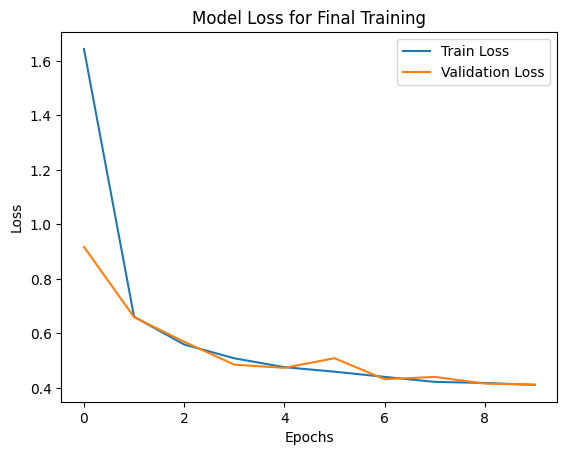

In [26]:
# Eğitim ve doğrulama kayıplarının grafiklerini çizme
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss for Final Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
test

array([[-0.33333333,  0.        , -0.98905216, ...,  0.74939797,
        -0.14390832,  0.93036433],
       [-0.33333333,  0.        , -0.96493021, ...,  0.74939797,
        -0.14390832,  0.93036433],
       [-0.33333333,  0.        , -0.9407933 , ...,  0.74939797,
        -0.14390832,  0.93036433],
       ...,
       [ 0.        , -0.25      ,  0.9748601 , ..., -0.53838301,
         0.56486736, -0.56444379],
       [ 0.        , -0.25      ,  1.00030897, ..., -0.53838301,
         0.56486736, -0.56444379],
       [ 0.        , -0.25      ,  1.02614236, ..., -0.53838301,
         0.56486736, -0.56444379]])

In [28]:
y_val_pred = model.predict(X_val)

236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step


In [29]:
y_val_pred.shape

(7545, 80, 1)

In [30]:
from sklearn.metrics import mean_absolute_error

mae_val = mean_absolute_error(y_val.reshape(-1), y_val_pred.reshape(-1))
print("Validation MAE:", mae_val)

Validation MAE: 0.41198819547941823


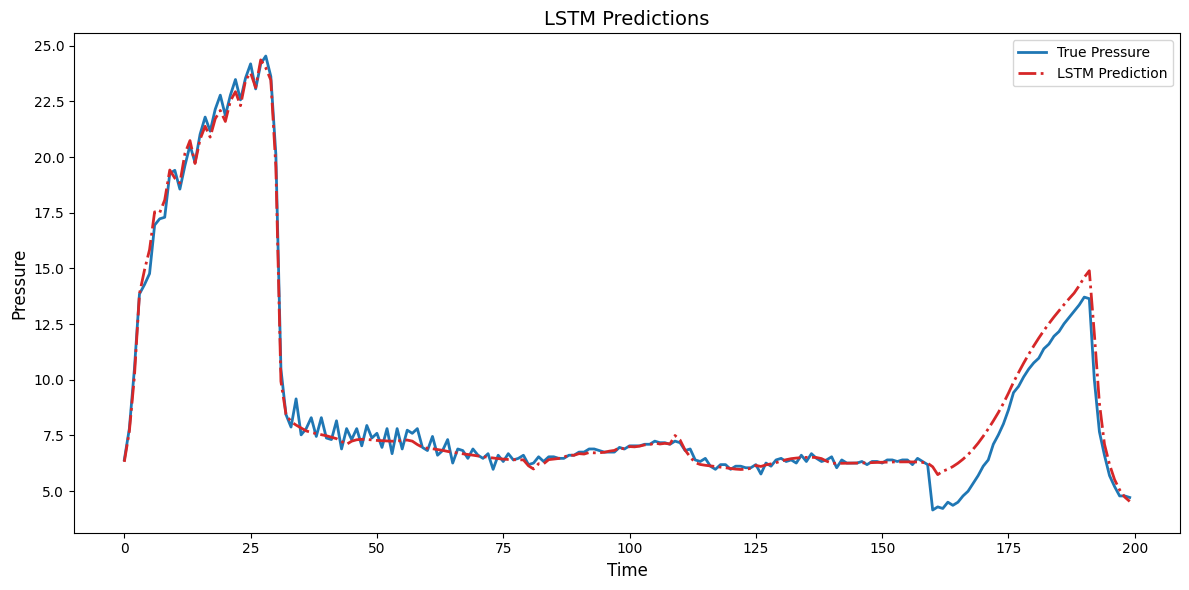

In [31]:
import matplotlib.pyplot as plt

# Plot true vs predicted pressures
plt.figure(figsize=(12, 6))
plt.plot(y_val.reshape(-1)[:200], label='True Pressure', color='#1f77b4', linewidth=2)
plt.plot(y_val_pred.reshape(-1)[:200], label='LSTM Prediction', color='#d62728', linestyle='-.', linewidth=2)

# Titles and labels
plt.title("LSTM Predictions", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Pressure", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
test_reshaped = test.reshape(-1, SEQ_LEN, num_features)

# Make predictions
predictions = model.predict(test_reshaped)
predictions = predictions.reshape(-1)

1572/1572 ━━━━━━━━━━━━━━━━━━━━ 42s 27ms/step


In [33]:
import pandas as pd

# Load the original test file again (with id column intact)
test_raw = pd.read_csv("/kaggle/input/ventilator-pressure-prediction/test.csv")

# Grab the ids
test_ids = test_raw['id'].values
print("test_ids shape:", test_ids.shape)

# Now create submission
submission = pd.DataFrame({
    "id": test_ids,
    "pressure": predictions
})

submission.to_csv("submission.csv", index=False)
print("✅ submission.csv saved!")


test_ids shape: (4024000,)
✅ submission.csv saved!
